# 군집 - DBSCAN(3)

## 학습 조건 설정

### API확인 
```python
class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
```

|파라미터|설명|
|---|---|
|eps|하나의 샘플에 대한 다른 샘플과의 최대 거리|
|min_samples|MinPts. 핵심 포인트로 간주할 포인트에 대한 이웃의 샘플 수|
|metric|피쳐배열에서 인스턴스 간의 거리르 계산할 때 사용되는 방법. 문자열 파라미터일 경우 "euclidean"로 명시. 그렇지 않을 경우 콜백함수 지정|
|metric_params|metric이 콜백함수로 지정될 경우 사용되는 파라미터|
|n_jobs|실행할 병렬 작업의 수. CPU의 프로세스 수만큼 설정가능|

![parameter](./res/parameter.png)

DBSCAN에서 가장 중요한 포인트는 `eps와 min_samples의 값을 결정`하는 것. 

입력 파라미터인 eps와 min_samples의 값을 구할 수 있는 공식 같은 것은 없다. 

다만 이를 결정하는데 도움을 받을 수 있는 주관적인 방법이 있을 뿐

### MinPts (min_samples)

2차원 데이터를 대상으로 실험을 한 결과 4,5 이상 간에는 큰 변동이 없다. 

MinPts 값이 점점 커질수록 연산량이 상당히 커지는 경향이 있으므로 2차원 데이터에서는 MinPts값을 4로 설정하는 것을 권장.

해당 분야 전문가가 제안하는 도메인 지식이 가장 우선되어야 한다. 

### eps

`sorted-k-dist` 그래프를 통해 eps값을 찾는다.

#### `sorted-k-dist` 그래프 작성방법

1. MinPts 를 k개라고 했을 때, 하나의 점으로부터 k개의 가장 가까운 점들간의 거리(k-dist)를 구한다.
2. `k-dist` 를 내림차순으로 정렬한다. 
3. 정렬결과를 lineplot으로 시각화 하여 기울기가 급격하게 변하는 지점의 eps값을 선정한다. 

### Ref

> Martin Ester, Hans-Peter Kriegel, Jorg Sander, Xiaowei Xu, 1996, "A Density-Based Algorithm for Discovering
Clusters in Large Spatial Databases with Noise", KDD-96

## #01. 패키지 참조

In [43]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations, product

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors # 차이: KNN 지도학습 <-> NearestNeighbors 비지도학습

# 군집평가지표
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score

## #02. 데이터셋 가져오기

In [4]:
origin = pd.read_excel('https://data.hossam.kr/G02/iris.xlsx')
origin

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [28]:
origin['Species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [30]:
labels = list(origin['Species'].map({"setosa":0, 'versicolor':1, 'virginica':2}))


## #03. 데이터 전처리

### 1. 필요한 변수만 분리

In [31]:
x = origin.drop('Species', axis=1)
x

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### 2. 데이터 표준화 수행

In [6]:
scaler = StandardScaler()

# 학습과 예측치 산정을 동시에 수행 (predict는 없음.)
# 만약 학습 결과를 재사용할 경우에는 transform()함수를 사용
n_data = scaler.fit_transform(x)
n_data[:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

## #04. Sorted-k-dist 그래프

- `NearestNeighbors`의 n_neighbors 파라미터: 가까운 이웃의 수(기본값=5)
- `DBSCAN`의 MinPts : 핵심 포인트가 되기 위한 이웃의 수 (기본값=5) 

In [32]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(n_data)
distances, indices = neighbors_fit.kneighbors(n_data)

In [33]:
distances[:5]

array([[0.        , 0.13163218, 0.13383627, 0.18772101, 0.23710977],
       [0.        , 0.16614339, 0.17890971, 0.17890971, 0.23710977],
       [0.        , 0.13383627, 0.17051228, 0.28389113, 0.31104122],
       [0.        , 0.23710977, 0.24891184, 0.2662756 , 0.28389113],
       [0.        , 0.17890971, 0.26013882, 0.27119749, 0.29154628]])

In [35]:
indices[:5]

array([[ 0, 17, 27, 40, 39],
       [ 1, 25, 12, 45, 34],
       [ 2, 47, 29,  3, 30],
       [ 3, 47, 30, 29,  2],
       [ 4, 37,  0, 40, 17]], dtype=int64)

In [37]:
# 거리를 내림차순으로 정리
s_distances = np.sort(distances, axis=0)
s_distances

array([[0.        , 0.        , 0.13383627, 0.17890971, 0.23710977],
       [0.        , 0.        , 0.13383627, 0.18772101, 0.23710977],
       [0.        , 0.12116787, 0.13383627, 0.18772101, 0.24891184],
       [0.        , 0.12116787, 0.13383627, 0.23710977, 0.24891184],
       [0.        , 0.12116787, 0.16614339, 0.23710977, 0.26013882],
       [0.        , 0.12116787, 0.17051228, 0.23710977, 0.26013882],
       [0.        , 0.13163218, 0.17051228, 0.23710977, 0.26013882],
       [0.        , 0.13163218, 0.17890971, 0.24891184, 0.26013882],
       [0.        , 0.13163218, 0.18772101, 0.24891184, 0.2662756 ],
       [0.        , 0.13163218, 0.18772101, 0.24891184, 0.2662756 ],
       [0.        , 0.13163218, 0.18772101, 0.26013882, 0.27119749],
       [0.        , 0.13163218, 0.18772101, 0.26517463, 0.27119749],
       [0.        , 0.13383627, 0.20917957, 0.2662756 , 0.28389113],
       [0.        , 0.13383627, 0.23710977, 0.2662756 , 0.28646987],
       [0.        , 0.13383627, 0.

In [11]:
# 1열만 출력
target = s_distances[:,1]
target

array([0.        , 0.        , 0.12116787, 0.12116787, 0.12116787,
       0.12116787, 0.13163218, 0.13163218, 0.13163218, 0.13163218,
       0.13163218, 0.13163218, 0.13383627, 0.13383627, 0.13383627,
       0.13383627, 0.13383627, 0.13383627, 0.13383627, 0.13383627,
       0.14337896, 0.14337896, 0.14337896, 0.14337896, 0.16614339,
       0.16614339, 0.16614339, 0.16614339, 0.16614339, 0.17051228,
       0.17051228, 0.17890971, 0.17890971, 0.17890971, 0.17890971,
       0.18772101, 0.18772101, 0.20917957, 0.21196853, 0.21196853,
       0.21196853, 0.21196853, 0.21196853, 0.21196853, 0.21541   ,
       0.21541   , 0.22734971, 0.22734971, 0.22734971, 0.22734971,
       0.23710977, 0.23710977, 0.23710977, 0.23710977, 0.23710977,
       0.23710977, 0.23710977, 0.24233574, 0.24233574, 0.24233574,
       0.24233574, 0.24891184, 0.25673434, 0.26013882, 0.26013882,
       0.26013882, 0.26013882, 0.26013882, 0.26270691, 0.26517463,
       0.2662756 , 0.2662756 , 0.2662756 , 0.2662756 , 0.26627

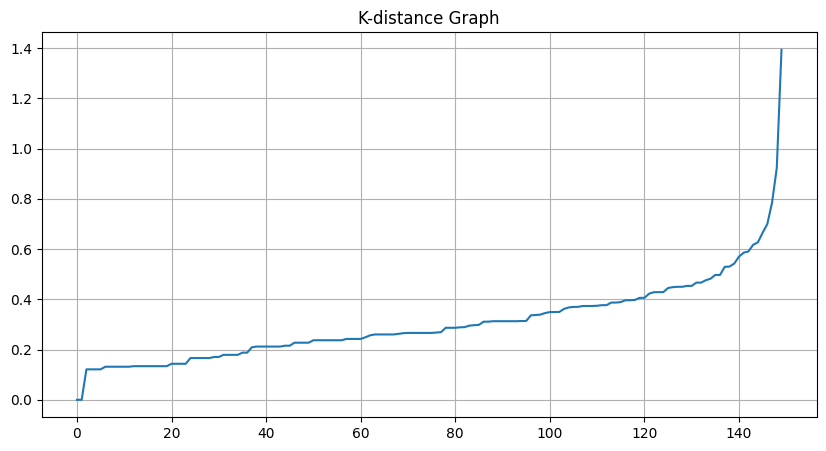

In [12]:
# 1열만 시각화해보기
plt.figure(figsize=(10,5))
plt.plot(target)
plt.grid()
plt.title('K-distance Graph')
plt.show()
plt.close()

> x축: min_samples, y축: eps

> 시각화 한 결과 eps값을 0.5와 0.6으로 각각 설정하여 군집 결과를 비교

## #05. DBSCAN 모델 구축

### 1. 조건값 설정

In [13]:
eps = [0.5, 0.6]
minPts = [4, 5]

In [16]:
# 두 리스트의 원소를 조합하여 경우의 수 생성
# * = unpacking 연산
prod = list(product(*[eps, minPts]))
prod

[(0.5, 4), (0.5, 5), (0.6, 4), (0.6, 5)]

### 2. 군집화 및 결과 평가

#### 결과 평가

| 상황 | 평가지표 |
|--|--|
| 목적변수가 있는 경우 | Homogeneity, Completeness, V-measure |
| 목적변수가 없는 경우 | Silhouette coefficient |

##### Homogeneity (동질성)
- 각 클러스터의 모든 객체들이 동일한 클래스로부터 온 객체들 일 때, 클러스터링 결과는 동질성을 만족시킴.
- 0.0에서 1.0까지의 분포를 나타내며 값이 클수록 좋음.

##### Completencess(완전성)
- 각 클래스의 모든 객체들이 동일한 클래스의 멤버가 될 때, 클러스터링 결과는 완전성을 만족시킴.
- 척도 값이 클수록 좋은 알고리즘으로 평가

##### V-measure(조화평균)
- Homogeneity와 Completencessdml whghk vudrbs
- 동질성 및 완전성 기준이 얼마나 성공적으로 충족되었는지 명시적으로 측정
- 0.0 과 1.0 사이의 양수값을 가지며 클수록 좋음. 
- 표본 수가 1000개 이상이고 군집 수가 10개 미만인 경우

##### API (Adjusted Rand Index)
- 타겟값으로 클러스터링 결과를 평가
- 1과 0사이의 값을 제공 (1=최적, 0=무작위)
- 표본의 크기가 작거나 군집 수가 많은 경우 사용.

##### Silhouette 계수
- 앞의 다른 지표와 다르게 레이블이 없는 군집용 지표
- 1과 0 사이의 값을 제공 (1=최적, 0=무작위)
- 각 군집간의 거리가 얼마나 효율적으로 분리되어 있는가를 나타냄.
    * 1에 가까운 값 : 근처의 다른 군집과 거리가 멀다는 의미
    * 0에 가까운 값 : 근처의 다른 군집과 거리가 가깝다는 의미
- 음수값이 나타나는 경우 : 잘못된 분류

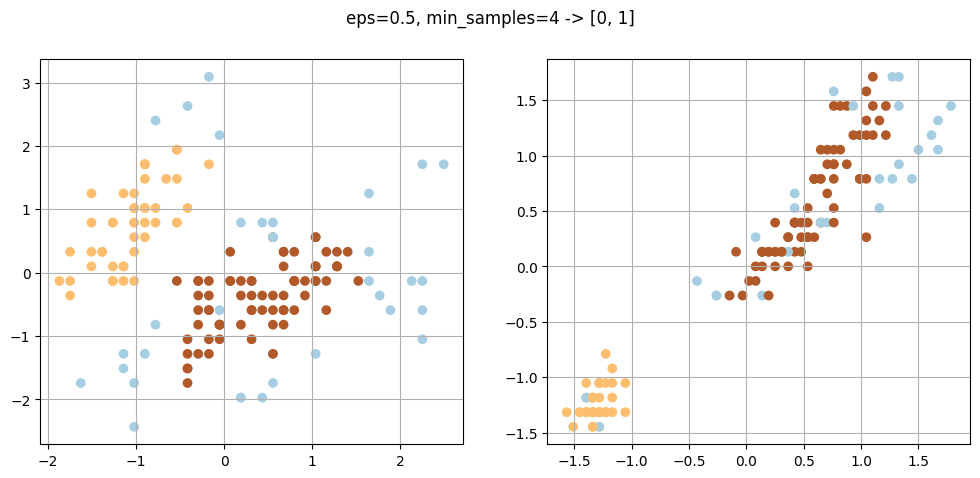

homogeneity_score 0.5039423719520235
completeness_score 0.5289839099785134
v_measure_score 0.516159596250751
adjusted_rand_score 0.44747527301949164
silhouette_score 0.36457435678297534


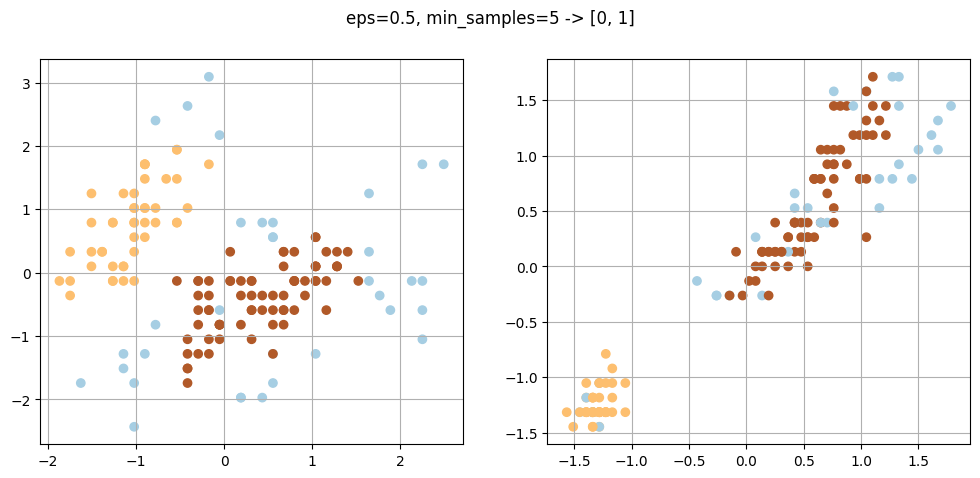

homogeneity_score 0.5005010857048665
completeness_score 0.522846554194579
v_measure_score 0.5114298559522713
adjusted_rand_score 0.4420986685885924
silhouette_score 0.35651648142700726


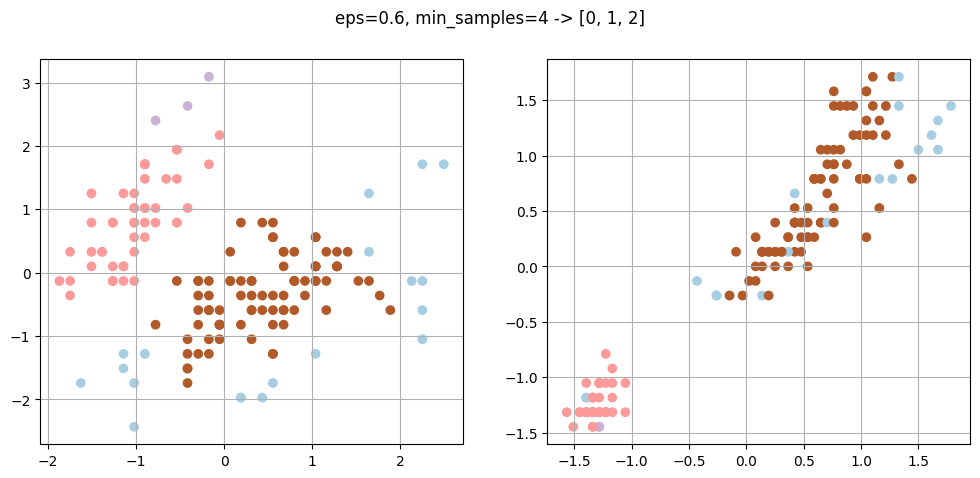

homogeneity_score 0.5589187595325174
completeness_score 0.5946623680973384
v_measure_score 0.576236807549922
adjusted_rand_score 0.48541172995292864
silhouette_score 0.35568179506247927


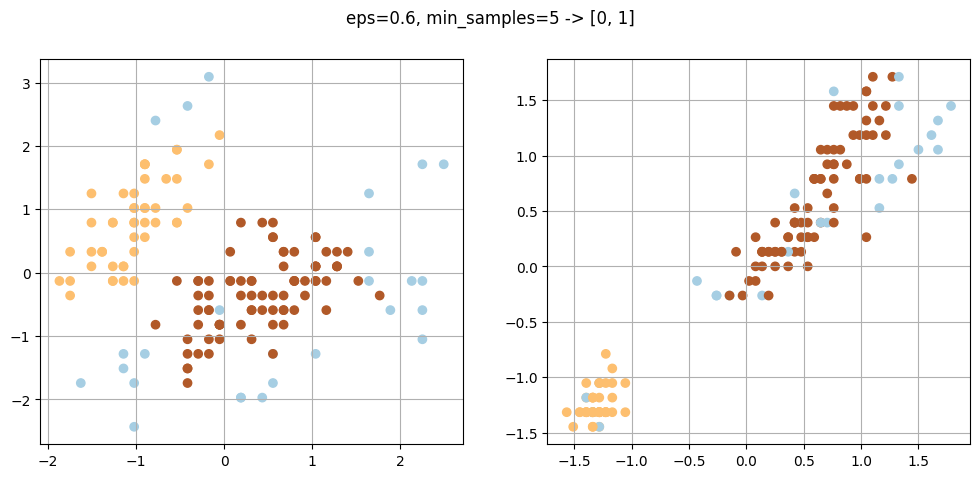

homogeneity_score 0.5180739608524721
completeness_score 0.5656029245001102
v_measure_score 0.5407961567255838
adjusted_rand_score 0.4706267335681117
silhouette_score 0.4027617471797909


In [46]:
for e,m in prod:
    dbscan = DBSCAN(eps=e, min_samples=m)
    # case1
    # dbscan.fit(n_data)
    # clusters = dbscan.labels_
    
    # case2
    clusters = dbscan.fit_predict(n_data)
    # print('eps=', e, ',min_samples=', m)
    # print("-" * 10)

    # 클러스터의 종류를 확인
    classes = list(set(clusters))
    class_result = list(filter(lambda x : x!= -1, classes))

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(x=n_data[:,0], y=n_data[:,1], c=clusters, cmap='Paired') #c 파라미터는 마커의 색상값을 나타낸다. 
    ax2.scatter(x=n_data[:,2], y=n_data[:,3], c=clusters, cmap='Paired')
    ax1.grid()
    ax2.grid()
    plt.suptitle('eps=%s, min_samples=%s -> %s' % (str(e), str(m), str(class_result)))
    plt.show()
    plt.close()

    print("homogeneity_score", homogeneity_score(labels, clusters))
    print("completeness_score", completeness_score(labels, clusters))
    print("v_measure_score", v_measure_score(labels, clusters))
    print("adjusted_rand_score", adjusted_rand_score(labels, clusters))
    print("silhouette_score", silhouette_score(n_data, clusters))

### 